# Защита персональных данных клиентов

Перед нами стоит задача защиты данных клиентов страховой компании «Хоть потоп». Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Необходимо так же обосновать корректность работы выбранного метода.

При этом нужно защитить данные так, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. В качестве алгоритма машинного обучения будет использоваться линейная регрессия.

Для решения задачи мы будем применять матричные операции к данным, а именно умножение имеющихся в нашем распояжении признаков на некую матрицу. Данный подход должен трансформировать персональную информацию так, что простая "человеческая" интерпретация её станет невозможной.

Для достижения поставленной цели мы будем придерживатья следующих шагов:

- загрузим и изучим данные;
- проверим, на какой тип матрицы мы в действительности можем умножить данные так, чтоб потом их можно было без потери информации восстановить
- напишем алгоритм шифрования данных и убедимся в его работоспособности
- подведём общий итог проделанной работе

_____

## Загрузим данные:

Импортируем необходимые для работы библиотеки и модули:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score

Техническая чать работы - соберём в одном месте написанные функции и класс. Так общий вид работы будет выглядеть немного аккуратнее:

In [2]:
def get_info(df):
    """
    функция выводит информацию о датафрейме и отрисовывает распределение признаков
    """
    
    display(df.head(3), df.tail(3), df.describe().T)
    
    num_cols, cat_cols = [], []
    for num, i in enumerate(df.columns):
        if pd.api.types.is_numeric_dtype(df[i]):
            print(f'{num+1}) {i} (числовой), оригинальных значений: {len(df[i].unique())}')
            num_cols.append(i)
        elif pd.api.types.is_object_dtype(df[i]):
            print(f'{num+1}) {i} (категориальный), оригинальных значений: {len(df[i].unique())}')
            cat_cols.append(i)
    print(f'\nитого:\nчисловых: {len(num_cols)}\nкатегориальных: {len(cat_cols)}\n'
          f'\nпропуски:\n{df.isna().sum()}\n\nдубликатов: {df.duplicated().sum()}')
    
    sns.set(style='whitegrid', palette='Set2')
    fig, ax = plt.subplots(1, 5, figsize=(20, 4), dpi=500)
    fig.suptitle('раcпределение значений признаков', fontsize=16, fontweight='bold')
    for num, col in enumerate(np.sort(df.columns)):
        if col == 'Возраст' or col == 'Зарплата': 
            ax[num].hist(df[col], color='#6ED9F5', edgecolor='#5AB3CB', bins=20)
        else:
            counts = df[col].value_counts()
            ax[num].pie(counts.values.tolist(), labels=counts.index.tolist(), startangle=90)
        ax[num].set_title(col)
    fig.tight_layout();
    

def create_an_invertible_matrix(lines=4, columns=4, get_inv_matrix=False):
    """
    функция возвращает случайную матрицу с проверкой её обратимости путем вычисления детерминанта
    если get_inv_matrix=True, то возвращается и сама матрица и матрица, обратная ей
    """
    
    matrix = np.random.rand(4,4)
    while np.linalg.det(matrix) == 0:
        matrix = np.random.rand(4,4)
    inv_matrix = np.linalg.inv(matrix)
    if get_inv_matrix:
        return matrix, inv_matrix
    else:
        return matrix
    
    
class MeasurementQualityPrediction:
    """
    класс: 
    1) обучает модель линейной регрессии и замеряет R2 для предсказания
    2) собирает полученные значения R2 для каждого экземпляра в единую сводную таблицу
    3) метод get_tsne_scatter при помощи TSNE преобразует данные в двумерное 
       пространство для их отрисовывки их на графике
    """
    
    df = pd.DataFrame(columns=['матрица', 'R2'])

    def __init__(self, X, y, name):
        
        self.X, self.y = X, y
        self.score = r2_score(self.y, LinearRegression().fit(self.X, self.y).predict(self.X))
        self.instance_name = name
        MeasurementQualityPrediction.df.loc[len(MeasurementQualityPrediction.df)] = [self.instance_name, self.score]

        
    def get_tsne_scatter(self, n_components=2, perplexity=30, learning_rate=200):
        
        sns.set_style('white')
        plt.figure(figsize=(12,4))
        tsne_model = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate)
        tsne_matrix = tsne_model.fit_transform(self.X)
        plt.scatter(tsne_matrix[:, 0], tsne_matrix[:, 1], marker='o', s=1, c='#009C47')
        plt.title(f't-SNE для "{self.instance_name}", компонент {n_components}', fontsize=16)
        plt.xlabel('компонента 1')
        plt.ylabel('компонента 2');

Загрузим данные и посмотрим на них:

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0
4999,1,28.0,40600.0,1,0


,count,mean,std,min,25%,50%,75%,max
Пол,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
Возраст,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
Зарплата,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
Члены семьи,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


1) Пол (числовой), оригинальных значений: 2
2) Возраст (числовой), оригинальных значений: 46
3) Зарплата (числовой), оригинальных значений: 524
4) Члены семьи (числовой), оригинальных значений: 7
5) Страховые выплаты (числовой), оригинальных значений: 6

итого:
числовых: 5
категориальных: 0

пропуски:
Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

дубликатов: 153


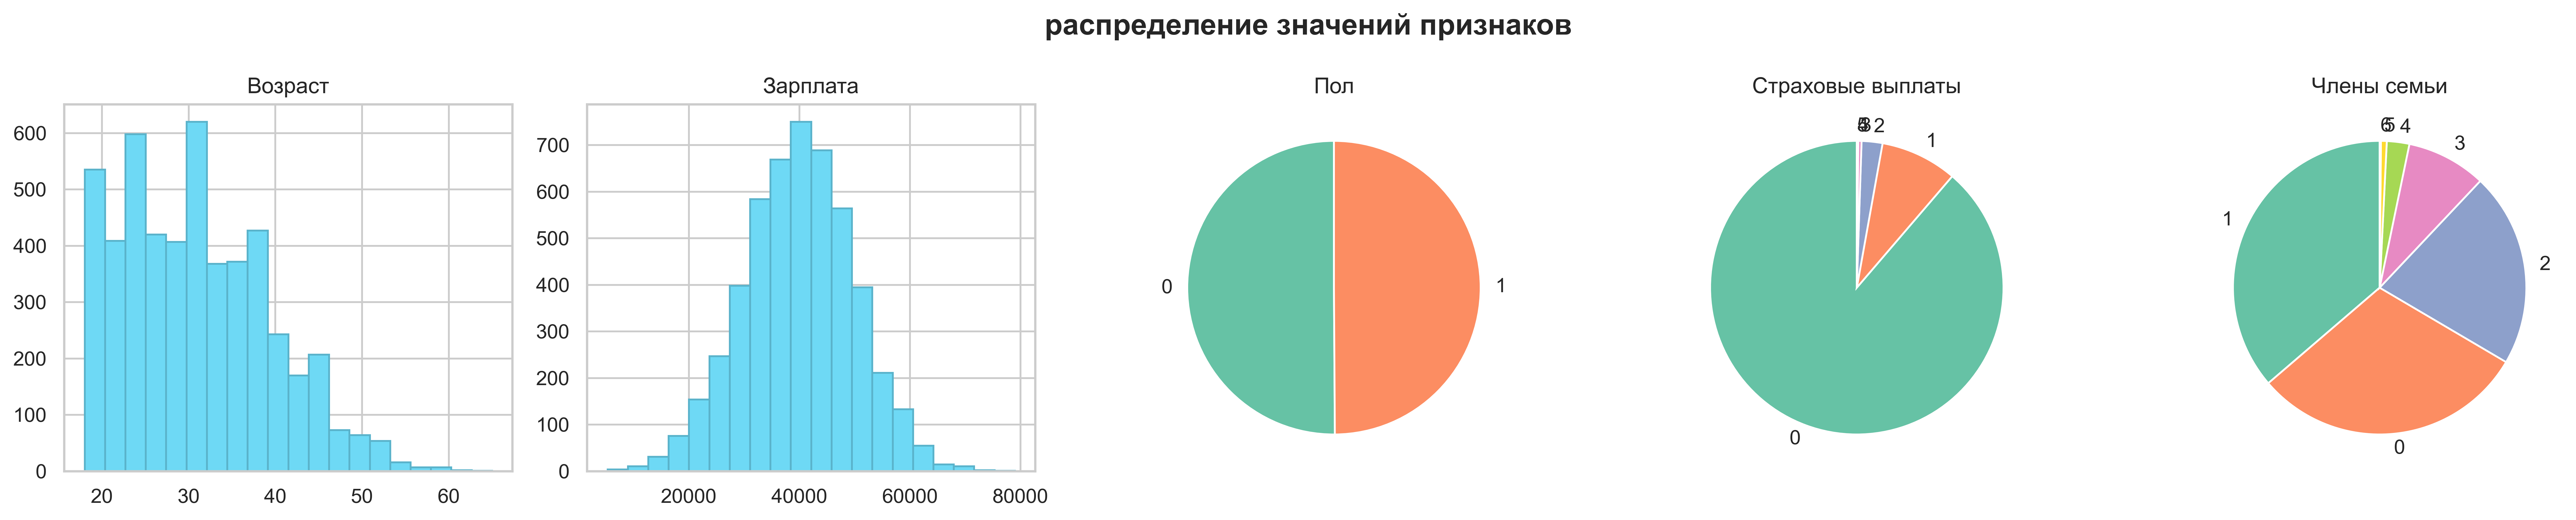

In [3]:
try:
    df = pd.read_csv('__insurance.csv')
except FileNotFoundError:
    df = pd.read_csv('https://___')
    
get_info(df)

Нашли явные дубликаты, удалим их:

In [4]:
df.drop_duplicates(inplace=True)

В целом данные выглядят адекватно, типы данных корректные, пропусков нет.

#### **Предварительный вывод.** На данном этапе мы:
- данные загрузили
- на них посмотрели. Видим, что у нас:
  - 5000 наблюдений
  - 4 признака + 1 таргет. Из наблюдений здесь можно отметить:
    - пол распределён поровну
    - для большинства клиентов страховые выплаты не оформлены
    - признаки возраста, зарплаты и количества членов в семье выглдят адекватно и не вызывают подозрений
  - 0 пропусков
  - 153 дубликата
  - все признаки числовые
- явные дубликаты удалили

$\Rightarrow$ данные готовы к работе

_____

## Рассмотрим некоторые особенности при умножении матриц друг на друга:

До какой-либо трансформации данных проведём исследование и ответим на вопрос, **при умножении признаков на обратимую матрицу изменится ли качество линейной регрессии?** 
Для начала подготовим имеющиеся у нас данные - выборку сделаем матрицей, а таргет вектором, и то и другое типом *array*:

In [5]:
X=df.drop(columns='Страховые выплаты').values
y=df['Страховые выплаты'].values
print(f'тип данных:\n\t{type(X)=}\n\t{type(y)=}\nразмеры:\n\t{X.shape=}\n\t{y.shape=}')

тип данных:
	type(X)=<class 'numpy.ndarray'>
	type(y)=<class 'numpy.ndarray'>
размеры:
	X.shape=(4847, 4)
	y.shape=(4847,)


Для оценки моделей мы будем использовать значение метрики ```R2``` (коэффициент детерминации), она применяется для оценки качества модели регрессии и измеряет то, насколько хорошо модель соответствует данным. ```R2```  принимает значения от 0 до 1, чем ближе к единице, тем лучше. Если же значение близко к нулю, то это говорит о том, что модель не уловила закономерностей в данных и не объясняет их вариацию. Формула:

$$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y_i})^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$$

$y_i$ - фактические значения целевой переменной 

$\hat{y_i}$ - предсказанные значения целевой переменной 

$\bar{y}$ - среднее значение целевой переменной

Для убедительного доказательства нам нужно с чем-то сравнивать $\Rightarrow$ выше $\uparrow \uparrow \uparrow$ нами был написан класс, который для своих экземпляров в конструкторе обучает модель линейной регрессии, делает предсказание, находит значение метрики $R2$ и собирает его в единую сводную таблицу.

Базовое значение $R2$ сохраним в переменную ```first_prediction```:

In [6]:
first_prediction = MeasurementQualityPrediction(X, y, 'базовая матрица')
print(f'R2 для first_prediction = {first_prediction.score}')

R2 для first_prediction = 0.4302010044852067


Ответ на вопрос, изменится ли качество линейной регрессии при умножении признаков на обратимую матрицу, связан с тем, как изменяется матрица признаков после умножения её на обратимую. Если умножение на обратимую матрицу не меняет количество признаков и сохраняет линейную независимость между признаками, то качество линейной регрессии не изменится.

Имея матрицу признаков $X$, мы можем умножить ее на некую обратимую матрицу $A$ и получить новую матрицу признаков $X′=XA$. Затем мы можем обучить новую модель линейной регрессии на этих преобразованных признаках и сравнить её качество с исходной моделью. Это и сделаем:

In [7]:
A, A_ = create_an_invertible_matrix(get_inv_matrix=True)
print(f'случайная матрица А:\n{A}\n\nобратная матрица случайной матрицы A:\n{A_}')

случайная матрица А:
[[0.6131802  0.75685067 0.7339717  0.93651407]
 [0.86699634 0.67453944 0.95431422 0.1401178 ]
 [0.46356397 0.28438692 0.01235196 0.15071582]
 [0.18857416 0.84729636 0.680492   0.54096418]]

обратная матрица случайной матрицы A:
[[ 0.39629482  0.49361257  1.17394774 -1.14098512]
 [-1.55764502 -0.44139954  1.96518647  2.26340255]
 [ 0.49433258  1.02437308 -2.38386229 -0.45695549]
 [ 1.67971679 -0.76930054 -0.48852094 -0.72399964]]


Умножим нашу матрицу признаков $X$ на обратимую матрицу $A$, предскажем на ней таргет $y$ и посчитаем ```R2```:

In [8]:
X_ = X @ A
second_prediction = MeasurementQualityPrediction(X_, y, 'обратимая матрица')
print(f'R2 для second_prediction = {second_prediction.score}')

R2 для second_prediction = 0.43020100448520815


Видим, что значения в ```first_prediction``` и ```second_prediction``` до определённого знака после запятой одинаковы, посмотрим, до какого знака:

In [9]:
num = 0
for i in range(20, 0, -1):
    if np.round(first_prediction.score, i) == np.round(second_prediction.score, i):
        num = i
        break
print(f'{np.round(first_prediction.score, num)=}\n{np.round(second_prediction.score, num)=}\nпосле запятой {num} знаков')

np.round(first_prediction.score, num)=0.43020100448521
np.round(second_prediction.score, num)=0.43020100448521
после запятой 14 знаков


Так как мы работаем с типом данных *float*, минимальная погрешность в вычислениях для этого типа допустима. В нашем примере предсказания идентичны аж до 13-го знака после запятой. И это доказывает то, что **при умножении признаков на обратимую матрицу качество линейной регрессии не изменяется**.

Как же так получается?

Допустим, что $y=f(X)$ - это зависимая переменная, которую мы предсказываем с помощью линейной регрессии. Умножая столбцы матрицы $X$ на матрицу $A$ мы получаем новую матрицу $X′=XA$. И тогда мы можем записать уравнение линейной регрессии для $X′$ следующим образом:

$y=w_0+w_1x′_1+w_2x′_2+...+w_px′_p$
 

где $x′_i$ - это i-ый столбец матрицы $X′$. 

Так как $X′=XA$, то мы можем выразить $x′_i$ через столбец $x_i$ и матрицу $A$:

$x′_i = x_iA$

Подставляя это выражение в уравнение линейной регрессии, мы получим:

$y = w_0 + w_1(x_1A) + w_2(x_2A) + ... + w_p(x_pA)$

$y = w_0 + w_1x_1A + w_2x_2A + ... + w_px_pA$

Из этого уравнения видно, что параметры $w_i$ будут различными для модели, построенной на преобразованных признаках $X′$, чем для модели, построенной на исходных признаках $X$. Однако, если матрица $A$ является обратимой, то мы можем найти прямую связь между двумя наборами параметров:

$w = w′A^{-1}$

где $w$ - это вектор параметров для модели, построенной на исходных признаках $X$, а $w′$ - это вектор параметров для модели, построенной на преобразованных признаках $X′$. Таким образом, мы видим, что параметры линейной регрессии линейно связаны между собой тогда, когда матрица $A$ обратима.

$\Rightarrow$ если мы можем найти обратимую матрицу $A$, которая сохраняет линейную независимость между признаками и не меняет их количество, то и качество линейной регрессии не изменится. 

Если же матрица $A$ необратима, то мы можем потерять линейную независимость между признаками и их количеством и это допускает риск изменения качества линейной регрессии. Например, если мы умножим матрицу $X$ на вырожденную матрицу, то один из столбцов матрицы $X$ может быть линейной комбинацией других столбцов, что приведет к потере информации и снижению качества линейной регрессии.

**Этот вопрос можно также рассмотреть с точки зрения геометрической интерпретации линейной регрессии.**

![lin_reg.md.png](https://ltdfoto.ru/images/2023/05/25/lin_reg.md.png)

Каждый столбец матрицы признаков $X$ размерности $(n$x$p)$ - это вектор в $p$-мерном пространстве. А цель линейной регрессии - найти гиперплоскость, которая наилучшим образом аппроксимирует эти векторы. 

Если мы умножаем матрицу $X$ на обратимую матрицу $A$, то мы фактически поворачиваем исходное пространство на некоторый угол и масштабируем его. Однако, если матрица $A$ обратима, то все исходные векторы остаются линейно независимыми и сохраняют свое количество. Таким образом, мы по-прежнему можем найти гиперплоскость, которая наилучшим образом аппроксимирует эти векторы, и качество линейной регрессии не изменится.

Если же матрица $A$ необратима, то это означает, что некоторые из исходных векторов могут являться линейной комбинацией других векторов, и тогда мы не cможем найти подходящую гиперплоскость. Как следствие, качество линейной регрессии может ухудшиться.

Вот подробная [статья](https://habr.com/ru/articles/514818/) на Хабре на тему геометрической интерпретации линейной регрессии. А вот работа некоего К.В. Воронцова на сайте Вычислительного центра (ВЦ РАН) «Информатика и управление», в ней тоже много интересного, скачать её можно [здесь](https://drive.google.com/file/d/1ciKaybYh5dklVTZ-w6GKPmFGyrJ0M5c5/view?usp=sharing) или [здесь](http://www.ccas.ru/voron/download/Regression.pdf)

_____

Но что же это мы будем останавливаться! **Докажем то, что качество линейной регрессии при умножении признаков на обратимую матрицу не меняется, ещё и на основе свойств матриц!** Для доказательства определим следующие обозначения:

- $X$ - это матрица признаков, нулевой столбец у которой состоит из единиц
- $y$ - это вектор целевого признака
- $A$ - это матрица, на которую признаки будут умножаться
- $w$ - вектор весов линейной регрессии (нулевой элемент равен сдвигу)
- $\alpha$ - это вектор предсказаний, он получается путём умножения матрицы признаков $X$ на вектор весов $w$, то есть $\alpha = Xw$
- $w=\underset{w}{\operatorname{argmin}} MSE(Xw,y)$ - это метод наименьших квадратов, это задача линейной регрессии
- $ w = (X^T X)^{-1} X^T y $ - формула обучения

1) Итак, если мы домножим матрицу $X$ на обратимую матрицу $A$, то получим следующие формулы для предсказаний и весов:

$\alpha = XAw$

$w′ = ((XA)^TXA)^{-1}(XA)^Ty$

2) подставим веса $w′$ в формулу для $\alpha$:

$\alpha = XA((XA)^T)XA^{-1}(XA)^Ty)$

3) теперь нам пригодится свойство транспонирования матриц, согласно которому транспонированное произведение матриц равно произведению транспонированных матриц $(AB)^T = B^T A^T$, применим его:

$\alpha = XA((A^TX^TXA)^{-1}A^TX^Ty)$

4) есть также свойство произведения обратной матрицы, по которому обратная матрица от произведения двух матриц равна обратной матрице B (второй) к обратной матрице А (первой) $(AB)^{-1} = B^{-1} A^{-1}$. Зная это правило, вынесем $A$:

$\alpha = XA((X^TXA)^{-1}(A^T)^{-1}A^TX^Ty)$

$\alpha = XAA^{-1}((X^TX)^{-1}(A^T)^{-1}A^TX^Ty)$

5) есть и такое свойство для обратной матрицы $AA^{-1}=E$, поэтому представим матрицу $A$ как единичную $E$ и перепишем уравнение:

$\alpha = XE((X^TX)^{-1}(A^T)^{-1}A^TX^Ty)$

6) отметим так же, что и выражение $(A^T)^{-1}A^T$ будет равно единичной матрице $E$, так как умножение матрицы на её обратную дает единичную матрицу. Таким образом, мы можем заменить и эту часть формулы на $E$, тогда получится:

$\alpha = XE((X^TX)^{-1}EX^Ty)$

7) поскольку произведение любой матрицы на единичную матрицу не изменяет саму матрицу, мы можем схлопнуть $E$ и получим:

$\alpha = X(X^TX)^{-1}X^Ty$

8) и вуаля! Вот к чему мы пришли - к исходному виду уравнения:

$\alpha = X(X^TX)^{-1}X^Ty = Xw$

$\Rightarrow$ для получения доказательства мы проделали ряд матричных преобразований, используя свойства матриц, и получили исходную формулу для $\alpha$. Это ещё раз говорит нам о том, что качество линейной регрессии при умножении признаков на обратимую матрицу не меняется, мы не потеряем информацию о данных и можем смело использовать такой подход для их шифрования/дешифрования. 

_____

**Теперь сформируем необратимую матрицу, предскажем на ней таргет и посчитаем $R2$:**

In [10]:
# Создадим вырожденную матрицу B, её детерминант = 0, она необратима
B = np.array([[5, 0, 0, 0],
              [0, 5, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 5]])
# проверим детерминант:
print('матрица невырожденная') if np.linalg.det(B) else print('матрица вырожденная')

# Умножим нашу матрицу признаков X на матрицу B
X_times_B = np.dot(X, B)

# предскажем 𝑦 и посчитаем R2:
third_prediction = MeasurementQualityPrediction(X_times_B, y, 'необратимая матрица')

print(f'R2 для third_prediction = {third_prediction.score}')

матрица вырожденная
R2 для third_prediction = 0.4301922802821906


Посмотрим в сводной таблице на метрику ```R2``` наших матриц:

In [11]:
MeasurementQualityPrediction.df

,матрица,R2
0,базовая матрица,0.430201
1,обратимая матрица,0.430201
2,необратимая матрица,0.430192


На нашем примере с очевидно вырожденной матрицей мы видим, что может возникнуть такая ситуация, при которой качество линейной регрессии, если и изменилось, то как будто бы незначительно. Но:
- оно изменилось и это уже плохо
- мы работаем с действительными данными и искажение информации, пусть, казалось бы, и незначительное, но в неизвестных местах, просто недопустимо при шифровании/дешифровании информации

Убедиться в том, что необратимая вырожденная матрица действительно поломала нам данные и регрессию мы можем и графически. Для этого визуализируем данные при помощи ```t-SNE```-алгоритма, который отлично подходит для визуализации многомерных данных в двумерном пространстве и отображает точки из исходного многомерного пространства в новом пространстве таким образом, что близкие точки из исходного пространства оказываются близко друг к другу, а далёкие - далеко:

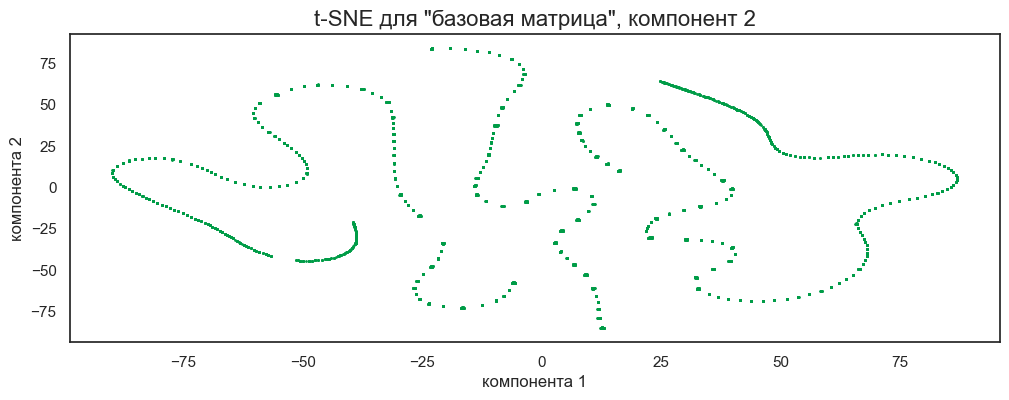

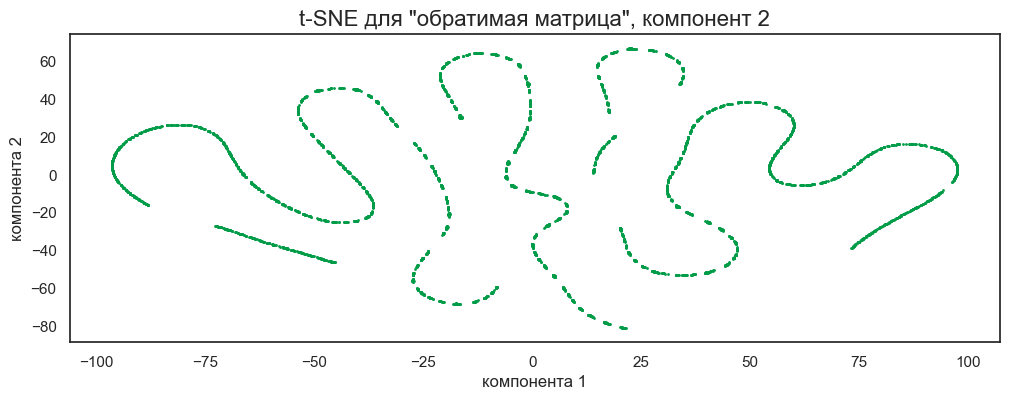

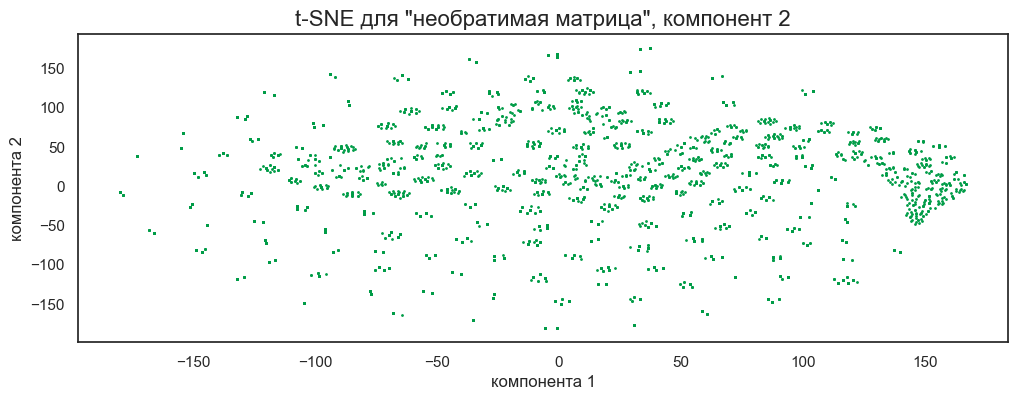

In [12]:
for i in [first_prediction, second_prediction, third_prediction]:
    i.get_tsne_scatter()

На первых двух t-SNE-графиках мы видим волнистые линии из точек, они могут указывать на наличие какой-то структуры в данных, возможно, что данные имеют явные кластеры, и точки расположены вдоль этих кластеров.

Умножение же признаков на необратимую матрицу привело к полному и необратимому изменению данных, то есть к тому, что кластеры, которые были видны на первых двух графиках, на третьем графике поменяли свою структуру, заняли больше площади и в целом расположились совсем иначе. 

Подобная визуализация наших матриц ещё раз показывает нам то, как сильно могут измениться данные при умножении их на необратимую матрицу. Качество предсказания модели линейной регрессии согласно ```R2``` как будто бы изменилось на самую малость, но при этом подобная модель уже не подойдёт для трансформирования данных. А самая главная проблема здесь заключается в том, что эти данные обратно вернуть уже не получится, так как третья матрица необратимая, её детерминант = 0, а значит и данные по ней обратно уже не восстановить.

#### **Предварительный вывод.** На данном этапе мы:
- проверили и убедились в том, что: 
  - при умножении признаков на обратимую матрицу качество линейной регрессии не меняется
  - но при умножении признаков на необратимую матрицу качество линейно регрессии может пострадать, а, самое главное, мы рискуем потерять возможность восстановления данных, зашифрованных таким способом.

$\Rightarrow$ для защиты данных клиентов важно обращать внмание на то, какая матрица будет использоваться для умножения признаков на неё. Эта матрица обязательно должна быть обратимой. 

_____

## Опробуем разработанный алгоритм преобразования данных:

Ранее мы выяснили то, что при умножении признаков на обратимую матрицу качество линейной регрессии не изменяется, а это значит то, что для защиты данных в качестве алгоритма их преобразования мы можем использовать матрицу со случайными значениями, но только такую, для которой возможно вычисление обратной матрицы.

Проведём эксперимент ещё раз и опробуем разработанный нами алгоритм, зашифровав и расшифровав обратно имеющиеся у нас признаки: 

Вот так наша таблица на самом деле выглядят: 

In [13]:
pd.DataFrame(X, columns=df.columns[:-1]).head(3)

,Пол,Возраст,Зарплата,Члены семьи
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0


Умножим признаки на сгенерированную обратимую матрицу и посмотрим, как будет выглядеть "зашифрованный" датафрейм:

In [14]:
invertible_matrix = create_an_invertible_matrix()
encrypted_data = np.dot(X, invertible_matrix)

F1_encrypted_data = MeasurementQualityPrediction(encrypted_data, y, 'зашифрованная').score
print(f'{F1_encrypted_data=}')
display(pd.DataFrame(encrypted_data, columns=df.columns[:-1]).head(3))

F1_encrypted_data=0.4302010044852288


,Пол,Возраст,Зарплата,Члены семьи
0,45804.362866,34450.073029,27346.959222,33292.052902
1,35093.229102,26404.143049,20957.050071,25511.655814
2,19393.786958,14594.137631,11582.563874,14099.840766


Красота! данные зашифрованы и теперь ничего по ним понять нельзя. 

Теперь попробуем расшифровать значения, умножив зашифрованную матрицу на обратную матрицу, которая была ранее вычислена с использованием некоторой инвертируемой матрицы. Результат для наглядности округлим:

In [15]:
decrypted_data = np.dot(encrypted_data, np.linalg.inv(invertible_matrix)).round()

F1_decrypted_data = MeasurementQualityPrediction(decrypted_data, y, 'расшифрованная').score
print(f'{F1_decrypted_data=}')
display(pd.DataFrame(decrypted_data, columns=df.columns[:-1]).head(3))

F1_decrypted_data=0.4302010044852067


,Пол,Возраст,Зарплата,Члены семьи
0,1.0,41.0,49600.0,1.0
1,-0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,-0.0


$\Rightarrow$ Похоже на то, что нам удалось восстановить зашифрованные данные!

#### **Предварительный вывод.** На данном этапе мы:
- проверили разработанный ранее алгоритм шифровки/дешифровки значений таблицы, а именно:
  - зашифровали значения, замерили ```F1``` предсказания на зашифрованных значениях
  - расшифровали значения, замерили ```F1``` предсказания на расшифрованных значениях
- на каждом этапе выводили первые строки таблицы, что позволила наглядно убедиться в происходящих трансформациях данных.

_____

## Проведём контрольную проверку алгоритма:

Мы помним о том, что работаем с типом данных *float*, а он всё же даём незначительную погрешность в вычислении в далёком знаке после запятой $\Rightarrow$ для того, чтобы убедиться наверняка в том, что мы правильно расшифровали данные, мы округлим значения в матрицах до 10-ти знаков после запятой и:

- сравним сами матрицы, должны получить True
- вычислим разницу между исходными данными и расшифрованными данными, должен получиться 0.0
- дополнительно выведем таблицу с замерами ```F1``` по:
  - базовым значениям
  - зашифрованным значениям
  - расшифрованным значениям

In [16]:
print(f'{np.array_equal(np.round(X, 10), np.round(decrypted_data, 10))=}\n'
      f'{np.round(X - decrypted_data, 10).max()=}')
pd.concat([MeasurementQualityPrediction.df.head(1),
           MeasurementQualityPrediction.df.tail(2)])

np.array_equal(np.round(X, 10), np.round(decrypted_data, 10))=True
np.round(X - decrypted_data, 10).max()=0.0


,матрица,R2
0,базовая матрица,0.430201
3,зашифрованная,0.430201
4,расшифрованная,0.430201


#### **Предварительный вывод.** На данном этапе мы:
- провели контрольную проверку разработанного метода шифрования данных и убедились в том, что процесс шифровки/расшифровки данных проходит исправно

_____

## Общий вывод:

В данной работе перед нами стояла задача создания такого алгоритма преобразования данных, который смог бы скрывать персональную информацию о клиентах страховой компании "Хоть потоп". Для достижения поставленных целей мы:
- выбрали метод матричных преобразований, который путём умножения матрицы с данными на обратимую матрицу позволяет скрыть персональную информацию клиентов компании
- проверили и убедились в том, что матрица для умножения на данные должна быть именно обратимой, так как при умножении признаков на необратимую матрицу возникает существенный риск безвозвратной потери информации. Обработали этот риск, в результате чего наш алгоритм всегда проверяет сформированную матрицу на её обратимость, предварительно вычисляя для неё детерминант
- проверили работу алгоритма, зашифровав данные и расшифровав их обратно
- на каждом этапе исследования формировали предсказания и с помощью коэффициента детерминации ```R2``` замеряли, насколько хорошо модель соответствует данным. В результате проведённых замеров мы убедились в том, что значение ```R2``` для зашифрованных и расшифрованных данных совпадают. Это означает то, что и качество алгоритма линейной регрессии от шифрования данных путём преобразования матриц не теряется, а значит и зависимости между признаками сохраняются.

В целом, данный алгоритм преобразования данных может быть полезен в сфере защиты конфиденциальной информации и обеспечения безопасности данных. Он позволяет скрыть персональную информацию клиентов страховой компании, сохраняя при этом зависимости между признаками и качество модели линейной регрессии. Однако, стоит отметить то, что разработанный нами алгоритм преобразования конфиденциальных данных клиентов с целью их защиты может не до конца отвечать современным требованиям безопасности, так как:
- он достаточно прост 
- при больших данных он будет очень дорогим в потреблении ресурсов
- он не предполагает использования в своей работе таких понятий, как "ключ-значение", применяемых в симметричных алгоритмах шифрования (к примеру, алгоритм ```AES``` (Advanced Encryption Standard)). Вот пример его применения на Python:

        from Crypto.Cipher import AES
        key = b'...'
        iv = b'...'
        cipher = AES.new(key, AES.MODE_CBC, iv)
        X_encrypted = cipher.encrypt(X.tobytes())
        X_decrypted = np.frombuffer(cipher.decrypt(X_encrypted), dtype='uint8').reshape((X.shape[1], X.shape[0]))

$\Rightarrow$ разработанный нами алгоритм не является универсальным решением для всех задач по защите данных. Для каждой конкретной задачи требуется проведение отдельного анализа уязвимостей и рисков. Но при работе с небольшими объёмами данных он выгоден по потреблению ресурсов и хорошо подходит для быстрого преобразования данных с целью осуществления операционной деятельности в компании "Хоть потоп" и обеспечит предоставление доступа к реальным данным только для тех сотрудников компании, которым этот доступ действительно необходим в своей работе.

_____